In [ ]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

from astropy.modeling import fitting
from sunkit_spex.models.physical.albedo import Albedo
from sunkit_spex.models.physical.nonthermal import ThickTarget
from plotting.plotter import plot_fit_results
from sunkit_spex.models.physical.thermal import ThermalEmission
from sunkit_spex.models.scaling import InverseSquareFluxScaling
from sunkit_spex.models.instrument_response import MatrixModel
from sunkit_spex.spectrum.spectrum import SpectralAxis
from sunkit_spex.spectrum.spectrum import Spectrum
from sunkit_spex.extern.stix import STIXLoader


/home/jmitchell/anaconda3/envs/sunkit-spex-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir = '../spectra/210507/'
spec = STIXLoader(spectrum_file=dir+'stx_spectrum_2105070034.fits',srm_file=dir+'stx_srm_2105070034_trimmed_2.fits')

spec

{'photon_channel_bins': array([[  4.   ,   4.005],
       [  4.005,   4.015],
       [  4.015,   4.025],
       ...,
       [149.65 , 149.75 ],
       [149.75 , 149.85 ],
       [149.85 , 149.95 ]]), 'photon_channel_mids': array([  4.0025,   4.01  ,   4.02  , ..., 149.7   , 149.8   , 149.9   ]), 'photon_channel_binning': array([0.005, 0.01 , 0.01 , ..., 0.1  , 0.1  , 0.1  ]), 'count_channel_bins': array([[  4.,   5.],
       [  5.,   6.],
       [  6.,   7.],
       [  7.,   8.],
       [  8.,   9.],
       [  9.,  10.],
       [ 10.,  11.],
       [ 11.,  12.],
       [ 12.,  13.],
       [ 13.,  14.],
       [ 14.,  15.],
       [ 15.,  16.],
       [ 16.,  18.],
       [ 18.,  20.],
       [ 20.,  22.],
       [ 22.,  25.],
       [ 25.,  28.],
       [ 28.,  32.],
       [ 32.,  36.],
       [ 36.,  40.],
       [ 40.,  45.],
       [ 45.,  50.],
       [ 50.,  56.],
       [ 56.,  63.],
       [ 63.,  70.],
       [ 70.,  76.],
       [ 76.,  84.],
       [ 84., 100.],
       [100

/home/jmitchell/software/sunkit-spex-dev/sunkit_spex/extern/stix.py:507: UserWarning: 
do not update event times to (2021-05-07T18:53:00.000, 2021-05-07T19:09:46.919): covers attenuator state change. Don't trust this fit!
 Note: This error will appear if doing spectral fitting with multiple spectra and the selected event times are correct (this is because the _update_time funtion which initiates _update_srm runs for every event start/end time setting). In that case, ignore the warning.
  warnings.warn(


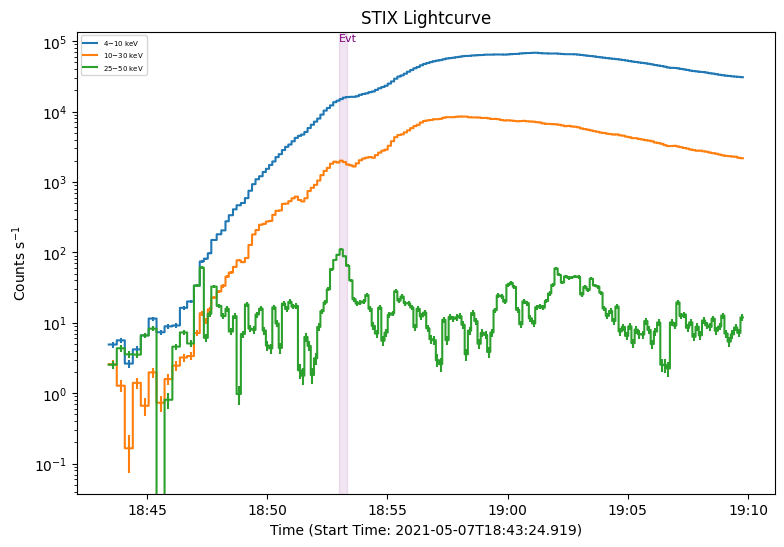

In [3]:
start = "2021-05-07T18:53:00"
end = "2021-05-07T18:53:20"

spec.start_event_time=start
spec.end_event_time=end

fig = plt.figure(figsize=(9,6))
spec.lightcurve(energy_ranges=[[4,10], [10,30], [25,50]])
plt.show()

In [4]:

count_channel_bins = spec['count_channel_bins']
indices_fit = np.where( (count_channel_bins[:,1] >= 5.0)  & (count_channel_bins[:,1] <= 55.0) )[0]
counts = (spec['count_rate'][indices_fit] *u.ct *u.keV**-1 *u.s**-1) 
counts_err = np.array(spec['count_rate_error'][indices_fit]) 

srm = spec['srm'][:,indices_fit]


In [5]:
obj_spec_photon  = Spectrum(counts,uncertainty=counts_err,spectral_axis=spec['photon_channel_bins']*u.keV)
obj_spec_counts = Spectrum(counts,uncertainty=counts_err,spectral_axis=spec['count_channel_bins'][indices_fit,:]*u.keV)

ph_energies_centers =  SpectralAxis._centers_from_edges(obj_spec_photon._spectral_axis._bin_edges)
counts_energies_centers =  SpectralAxis._centers_from_edges(obj_spec_counts._spectral_axis._bin_edges)


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


        Use numpy.iterable() instead. [gwcs.coordinate_frames]


In [6]:
srm_model = MatrixModel(
    matrix=srm, input_axis=obj_spec_photon._spectral_axis._bin_edges, output_axis=obj_spec_counts._spectral_axis._bin_edges, c=1 * u.ct *u.cm**2 * u.ph**-1, 
    _input_units={"x": u.ph *u.keV**-1 *u.s**-1 * u.cm**-2}, _output_units={"y": u.ct* u.keV**-1 * u.s**-1}
)

In [7]:
distance = InverseSquareFluxScaling(1*u.AU)
f_vth = ThermalEmission()
thick = ThickTarget(break_energy=1500*u.keV,low_e_cutoff=20*u.keV)
albedo = Albedo(energy_edges=obj_spec_photon._spectral_axis._bin_edges, theta=54.21*u.deg)

ph_model_4fit = (((f_vth + thick) * distance ) | albedo)  | srm_model


In [8]:
ph_model_4fit.theta_3.fixed = True

ph_model_4fit.temperature_0.fixed = False
ph_model_4fit.emission_measure_0.fixed = False

ph_model_4fit.break_energy_1.fixed= True
ph_model_4fit.low_e_cutoff_1.fixed = False
ph_model_4fit.q_1.fixed = False
ph_model_4fit.total_eflux_1.fixed = False


In [9]:
pfit = fitting.TRFLSQFitter()


new_model = pfit(ph_model_4fit,obj_spec_photon._spectral_axis._bin_edges, obj_spec_photon.data,
                 weights=1/obj_spec_photon.uncertainty.array,maxiter=100000)

/home/jmitchell/software/sunkit-spex-dev/sunkit_spex/models/physical/thermal.py:1301: UserWarning: Some input energy values outside valid range of 1.0002920302956426--10.34753795157738 keV. Flux will be zero outside this range.
  warnings.warn(message)


In [10]:
print(new_model)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: ([0] + [1]) * [2] | [3] | [4]
Components: 
    [0]: <ThermalEmission(temperature=15.92790373 MK, emission_measure=0.22087492 1 / cm3, mg=8.15, al=7.04, si=8.1, s=7.27, ar=6.58, ca=6.93, fe=8.1, name='ThermalEmission')>

    [1]: <ThickTarget(p=4.51503622, break_energy=1500. keV, q=3.20620065, low_e_cutoff=15.55299463 keV, high_e_cutoff=1500. keV, total_eflux=1.80119522 electron / s, name='ThickTarget')>

    [2]: <InverseSquareFluxScaling(observer_distance=1. AU, name='InverseSquareFluxScaling')>

    [3]: <Albedo(theta=54.21 deg, anisotropy=1., name='Albedo')>

    [4]: <MatrixModel(c=1. cm2 ct / ph, name='SRM')>
Parameters:
      temperature_0    emission_measure_0 mg_0 ... theta_3 anisotropy_3     c_4    
            MK              1 / cm3            ...   deg                cm2 ct / ph
    ------------------ ------------------ ---- ... ------- ------------ -----------
    15.927903731751773 0.2208749

ct / (keV s)


/home/jmitchell/software/sunkit-spex-dev/sunkit_spex/models/physical/thermal.py:1301: UserWarning: Some input energy values outside valid range of 1.0002920302956426--10.34753795157738 keV. Flux will be zero outside this range.
  warnings.warn(message)


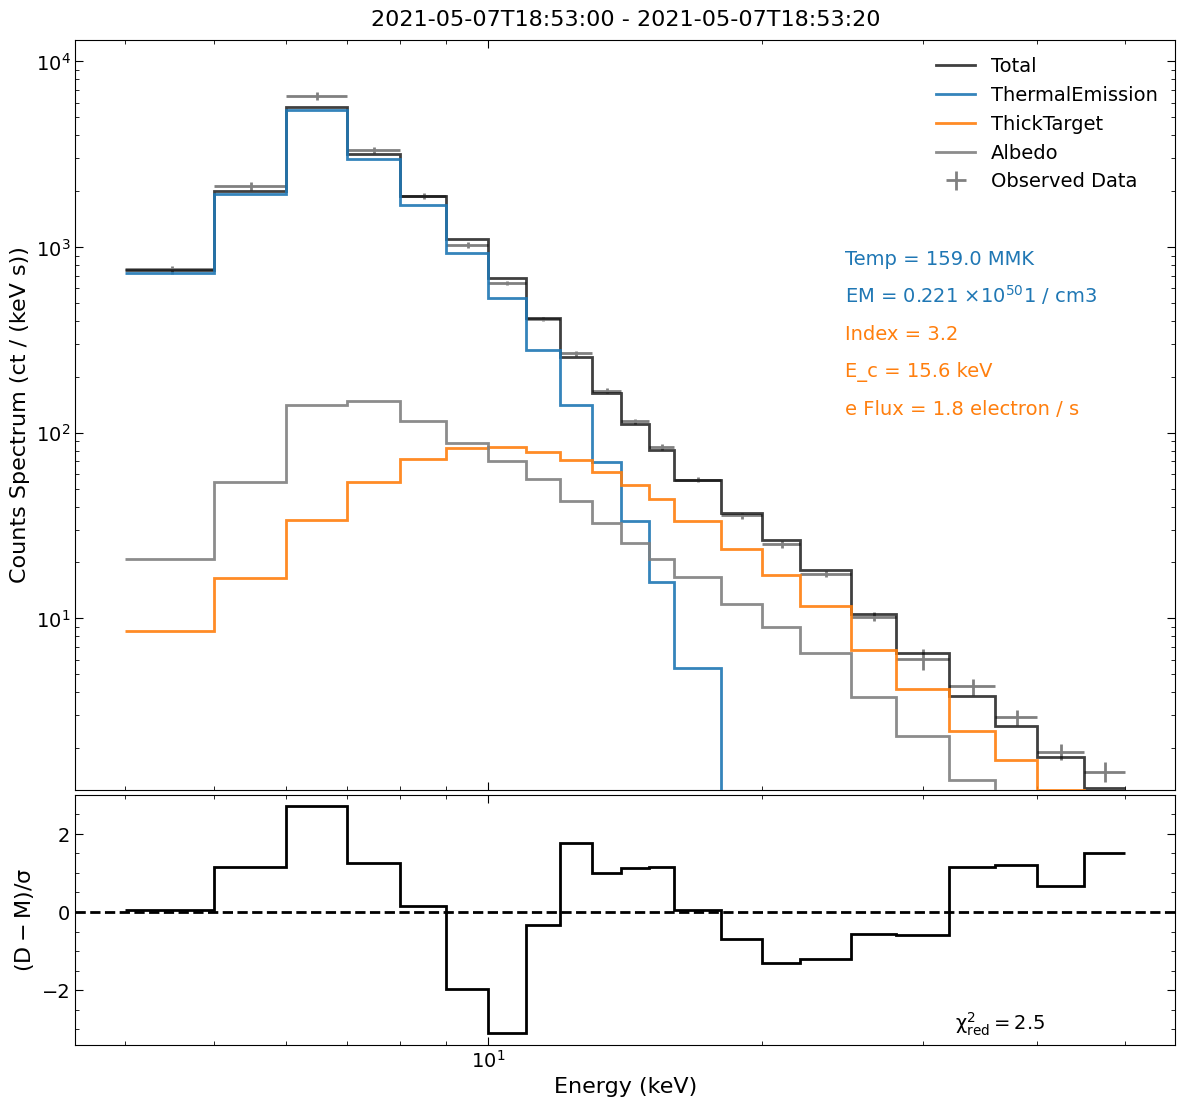

In [11]:
save_name = 'Sunkit-Spex_output.pdf'
fit_times = f'{start} - {end}'

print(obj_spec_counts.unit)
plot_fit_results(obj_spec_counts._spectral_axis._bin_edges,obj_spec_photon._spectral_axis._bin_edges,
                 obj_spec_counts.data << obj_spec_counts.unit,obj_spec_counts.uncertainty.array<< obj_spec_counts.unit,
                 new_model,save_name,fit_times)

In [12]:
new_model['ThermalEmission'](obj_spec_photon._spectral_axis._bin_edges) 

/home/jmitchell/software/sunkit-spex-dev/sunkit_spex/models/physical/thermal.py:1301: UserWarning: Some input energy values outside valid range of 1.0002920302956426--10.34753795157738 keV. Flux will be zero outside this range.
  warnings.warn(message)


<Quantity [1.93744170e+32, 1.92302671e+32, 1.90715095e+32, ...,
           5.90582474e-27, 5.47996529e-27, 5.08479383e-27] ph / (keV s)>

In [13]:
ph_model_4fit['ThermalEmission'](obj_spec_photon._spectral_axis._bin_edges) 

<Quantity [2.58046859e+32, 2.55323571e+32, 2.51788902e+32, ...,
           4.97272993e-81, 4.41911734e-81, 3.92712279e-81] ph / (keV s)>

In [14]:
new_model.fixed

{'temperature_0': False, 'emission_measure_0': False, 'mg_0': True, 'al_0': True, 'si_0': True, 's_0': True, 'ar_0': True, 'ca_0': True, 'fe_0': True, 'p_1': False, 'break_energy_1': True, 'q_1': False, 'low_e_cutoff_1': False, 'high_e_cutoff_1': True, 'total_eflux_1': False, 'observer_distance_2': True, 'theta_3': True, 'anisotropy_3': True, 'c_4': True}